**Importing the dataset from google drive, unzipping it and pre-processing**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip gdrive/MyDrive/alzheimers_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [2]:
!pip install imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef as MCC+
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold

#!pip install -U tensorflow-addons==0.11.2
!pip install -U tensorflow-addons==0.16.1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50


#from keras_efficientnets import EfficientNetB7
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

     |████████████████████████████████| 1.1 MB 14.4 MB/s 
TensorFlow Version: 2.8.0


In [6]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"
if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'NonDemented', 'ModerateDemented', 'VeryMildDemented']


In [7]:
WORK_DIR = './dataset/'
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

**Augmentation**

In [8]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [9]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

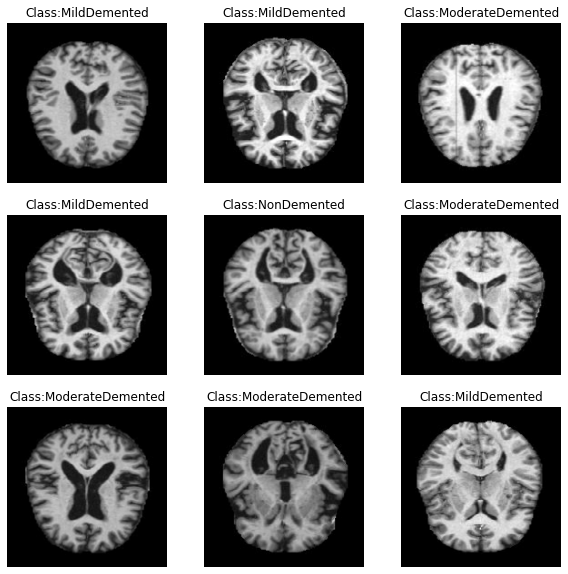

In [ ]:
show_images(train_data_gen)

In [9]:
train_data, train_labels = train_data_gen.next()

In [11]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


**SMOTE**

In [10]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


**Train-Test-Validation Split**     
train : test : validation = 64 : 20 : 16

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(8192, 176, 176, 3)
(2560, 176, 176, 3)
(2048, 176, 176, 3)


In [15]:
class MyCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
          if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

In [16]:
epochs = 25
IMG_HEIGHT = 176
IMG_WIDTH = 176

**Functions to create and fit base models**

In [17]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = Dense(4, activation='sigmoid')(global_average_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.losses.CategoricalCrossentropy(), metrics=["accuracy"])
    return model


def fit_model(model):
    history = model.fit(
                        train_data, train_labels,
                        epochs=epochs,
                        validation_data=(val_data, val_labels)
                        )
    return history

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**Initializing the base models**

base model 1 = InceptionV3  
base model 2 = Xception  
base model 3 = ResNet50

In [18]:
IMG_SHAPE = (176, 176, 3)
base_model1 = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model2 = Xception(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model3 = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(176, 176, 3)))

model1 = create_model(base_model1)
model2 = create_model(base_model2)
model3 = create_model(base_model3)

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
base_model2 = Xception(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

model2 = create_model(base_model2)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**InceptionV3 Training**

In [19]:
history1 = fit_model(model1)

Epoch 1/25
256/256 [==============================] - 52s 122ms/step - loss: 0.5551 - accuracy: 0.7554 - val_loss: 0.8268 - val_accuracy: 0.6855
Epoch 2/25
256/256 [==============================] - 29s 115ms/step - loss: 0.2078 - accuracy: 0.9188 - val_loss: 0.4971 - val_accuracy: 0.8447
Epoch 3/25
256/256 [==============================] - 29s 115ms/step - loss: 0.0935 - accuracy: 0.9664 - val_loss: 0.2187 - val_accuracy: 0.9194
Epoch 4/25
256/256 [==============================] - 29s 115ms/step - loss: 0.0791 - accuracy: 0.9729 - val_loss: 0.2915 - val_accuracy: 0.9121
Epoch 5/25
256/256 [==============================] - 29s 115ms/step - loss: 0.0612 - accuracy: 0.9774 - val_loss: 0.1807 - val_accuracy: 0.9385
Epoch 6/25
256/256 [==============================] - 29s 115ms/step - loss: 0.0308 - accuracy: 0.9897 - val_loss: 0.3009 - val_accuracy: 0.9106
Epoch 7/25
256/256 [==============================] - 29s 115ms/step - loss: 0.0376 - accuracy: 0.9866 - val_loss: 0.2001 - val_ac

In [ ]:
model1.save('saved_models/model1A.h5')

**Xception Training**

In [26]:
history2 = fit_model(model2)

Epoch 1/25
256/256 [==============================] - 73s 265ms/step - loss: 0.5092 - accuracy: 0.7782 - val_loss: 0.9827 - val_accuracy: 0.6157
Epoch 2/25
256/256 [==============================] - 67s 261ms/step - loss: 0.1468 - accuracy: 0.9473 - val_loss: 0.6884 - val_accuracy: 0.7354
Epoch 3/25
256/256 [==============================] - 67s 261ms/step - loss: 0.0624 - accuracy: 0.9781 - val_loss: 0.4717 - val_accuracy: 0.8579
Epoch 4/25
256/256 [==============================] - 67s 261ms/step - loss: 0.0397 - accuracy: 0.9869 - val_loss: 0.2245 - val_accuracy: 0.9268
Epoch 5/25
256/256 [==============================] - 67s 261ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.2681 - val_accuracy: 0.9209
Epoch 6/25
256/256 [==============================] - 67s 261ms/step - loss: 0.0342 - accuracy: 0.9888 - val_loss: 0.1983 - val_accuracy: 0.9365
Epoch 7/25
256/256 [==============================] - 67s 261ms/step - loss: 0.0273 - accuracy: 0.9894 - val_loss: 0.2769 - val_ac

In [ ]:
model2.save('saved_models/model2B.h5')

**ResNet50 training**

In [28]:
history3 = fit_model(model3)

Epoch 1/25
256/256 [==============================] - 43s 139ms/step - loss: 0.4828 - accuracy: 0.7942 - val_loss: 1.5439 - val_accuracy: 0.2422
Epoch 2/25
256/256 [==============================] - 34s 134ms/step - loss: 0.1573 - accuracy: 0.9423 - val_loss: 1.8822 - val_accuracy: 0.2461
Epoch 3/25
256/256 [==============================] - 34s 134ms/step - loss: 0.0657 - accuracy: 0.9774 - val_loss: 2.1978 - val_accuracy: 0.3394
Epoch 4/25
256/256 [==============================] - 34s 134ms/step - loss: 0.0428 - accuracy: 0.9843 - val_loss: 1.7593 - val_accuracy: 0.5146
Epoch 5/25
256/256 [==============================] - 34s 134ms/step - loss: 0.0487 - accuracy: 0.9832 - val_loss: 0.6212 - val_accuracy: 0.7983
Epoch 6/25
256/256 [==============================] - 34s 134ms/step - loss: 0.0317 - accuracy: 0.9907 - val_loss: 0.2322 - val_accuracy: 0.9243
Epoch 7/25
256/256 [==============================] - 34s 134ms/step - loss: 0.0424 - accuracy: 0.9858 - val_loss: 0.4903 - val_ac

In [ ]:
model3.save('saved_models/model3C.h5')

**Validation accuracy of InceptionV3**

In [30]:
final_accuracy1 = history1.history["val_accuracy"][-5:]
print("FINAL ACCURACY INCEPTIONV3 MEAN-5: ", np.mean(final_accuracy1))

FINAL ACCURACY INCEPTIONV3 MEAN-5:  0.94052734375


**Validation accuracy of Xception**

In [31]:
final_accuracy2 = history2.history["val_accuracy"][-5:]
print("FINAL ACCURACY XCEPTION MEAN-5: ", np.mean(final_accuracy2))

FINAL ACCURACY XCEPTION MEAN-5:  0.928125


**Validation accuracy of ResNet50**

In [32]:
final_accuracy3 = history3.history["val_accuracy"][-5:]
print("FINAL ACCURACY RESNET50 MEAN-5: ", np.mean(final_accuracy3))

FINAL ACCURACY RESNET50 MEAN-5:  0.91396484375


**Training and validation accuracies, losses of three models in order**

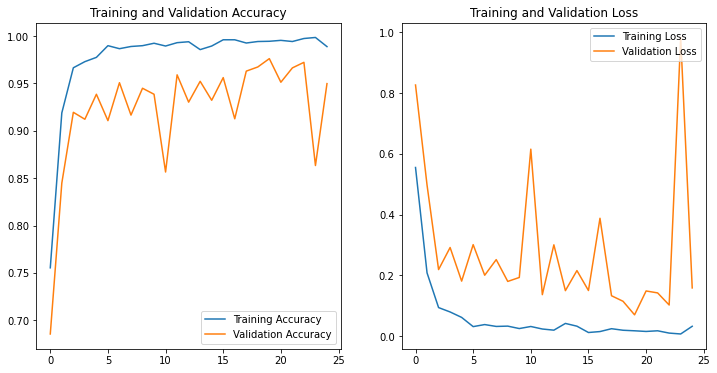

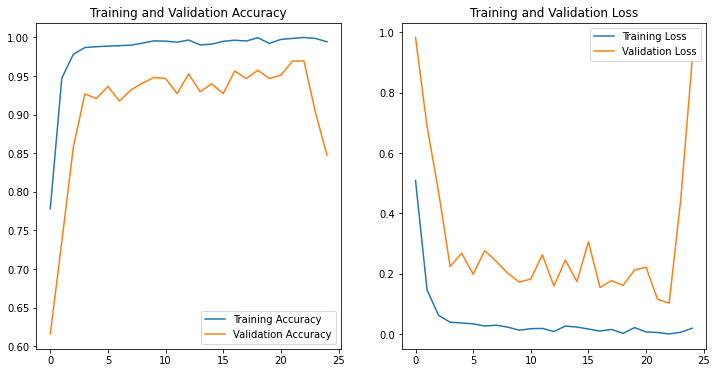

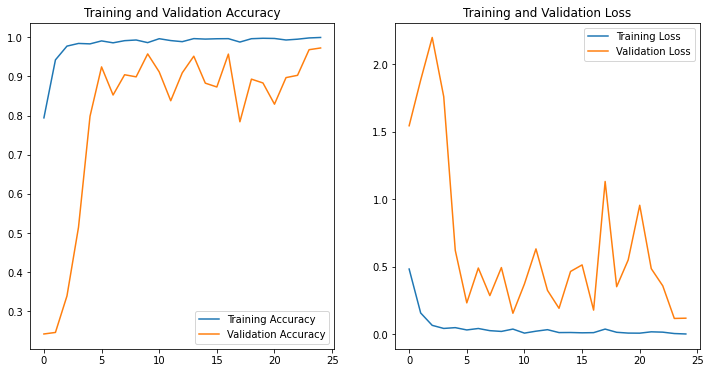

In [33]:
plot_history(history1)
plot_history(history2)
plot_history(history3)

**Testing accuracy of InceptionV3**

In [34]:
test_scores1 = model1.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores1[1] * 100))

80/80 [==============================] - 3s 37ms/step - loss: 0.1622 - accuracy: 0.9469
Testing Accuracy: 94.69%


**Testing accuracy of Xception**

In [35]:
test_scores2 = model2.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores2[1] * 100))

80/80 [==============================] - 4s 52ms/step - loss: 0.8791 - accuracy: 0.8551
Testing Accuracy: 85.51%


**Testing accuracy of ResNet50**

In [36]:
test_scores3 = model3.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores3[1] * 100))

80/80 [==============================] - 3s 40ms/step - loss: 0.0949 - accuracy: 0.9738
Testing Accuracy: 97.38%


**Loading saved trained based models**

In [ ]:
def load_all_models():
    all_models = []
    model_names = ['model1A.h5', 'model2B.h5', 'model3C.h5']
    for model_name in model_names:
        filename = os.path.join('saved_models', model_name)
        #filename=model_name
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

**Function to create ensemble**

In [38]:
def ensemble_model(models):
    for i, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    merge = tf.keras.layers.Dense(10, activation='relu')(merge)
    output = tf.keras.layers.Dense(4, activation='sigmoid')(merge)
    model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    return model

In [42]:
models = load_all_models()
model = ensemble_model(models)

loaded: sample_data/models/model1A.h5
loaded: sample_data/models/model2B.h5
loaded: sample_data/models/model3C.h5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
'''
X = [train_data for _ in range(len(model.input))]
X_1 = [test_data for _ in range(len(model.input))]
'''
X = [train_data for _ in range(3)]
X_1 = [test_data for _ in range(3)]

In [15]:
print(len(X))

3


**Ensemble training**

In [43]:
epochs = 50
history = model.fit(X, train_labels,
                    epochs=epochs,
                    validation_data=(X_1, test_labels)
                    )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


256/256 [==============================] - 59s 186ms/step - loss: 0.8831 - accuracy: 0.6863 - val_loss: 0.4374 - val_accuracy: 0.9660
Epoch 2/50
256/256 [==============================] - 42s 165ms/step - loss: 0.1789 - accuracy: 0.9990 - val_loss: 0.1268 - val_accuracy: 0.9781
Epoch 3/50
256/256 [==============================] - 42s 165ms/step - loss: 0.0433 - accuracy: 0.9999 - val_loss: 0.0812 - val_accuracy: 0.9777
Epoch 4/50
256/256 [==============================] - 42s 165ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.0679 - val_accuracy: 0.9781
Epoch 5/50
256/256 [==============================] - 42s 165ms/step - loss: 0.0114 - accuracy: 0.9998 - val_loss: 0.0625 - val_accuracy: 0.9781
Epoch 6/50
256/256 [==============================] - 42s 165ms/step - loss: 0.0076 - accuracy: 0.9998 - val_loss: 0.0596 - val_accuracy: 0.9781
Epoch 7/50
256/256 [==============================] - 42s 164ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 0.9

In [ ]:
model.save('saved_models/ensemble_model.h5')

In [16]:
model = tf.keras.models.load_model('ensemble_model.h5')

**Validation accuracy of ensemble**

In [45]:
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY ENSEMBLE MEAN-5: ", np.mean(final_accuracy))

FINAL ACCURACY ENSEMBLE MEAN-5:  0.9824999928474426


**training and validation accuracy and loss of ensemble**

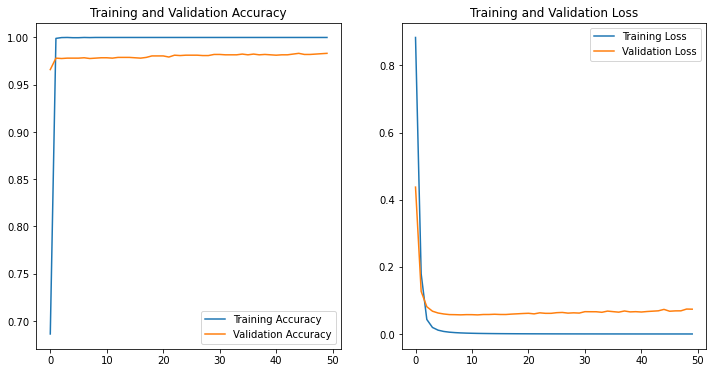

In [46]:
plot_history(history)

**Evaluation of Ensemble Performance**

In [17]:
from numpy import argmax

In [18]:
from sklearn.metrics import accuracy_score

In [28]:
test_labels[1]

array([0, 1, 0, 0])

In [29]:
rounded_labels=argmax(test_labels, axis=1)
rounded_labels[1]

1

In [ ]:
# make predictions and evaluate
yhat=model.predict([test_data, test_data, test_data])
yhat = argmax(yhat, axis=1)

In [32]:
len(yhat)

2560

In [33]:
acc = accuracy_score(rounded_labels, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.978


In [35]:
cm = confusion_matrix(rounded_labels, yhat)
cm

array([[630,   0,   3,   6],
       [  0, 632,   0,   3],
       [  5,   0, 633,  24],
       [  4,   0,  12, 608]])

In [37]:
print(classification_report(rounded_labels, yhat, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      0.99      0.99       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.98      0.96      0.97       662
ModerateDemented       0.95      0.97      0.96       624

        accuracy                           0.98      2560
       macro avg       0.98      0.98      0.98      2560
    weighted avg       0.98      0.98      0.98      2560



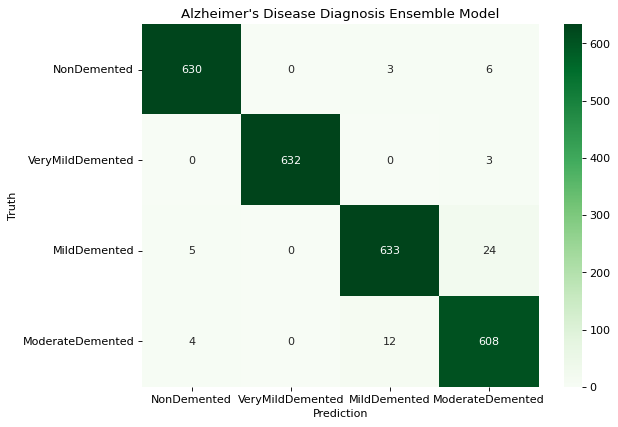

In [36]:
#pred_ls = np.argmax(pred_labels, axis=1)
#test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(rounded_labels, yhat)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis Ensemble Model')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

**Evaluation of InceptionV3**

In [38]:
model1 = tf.keras.models.load_model('model1A.h5')

In [39]:
yhat1=model1.predict(test_data)
yhat1 = argmax(yhat1, axis=1)
acc1 = accuracy_score(rounded_labels, yhat1)
print('Inception Test Accuracy: %.3f' % acc1)

Inception Test Accuracy: 0.935


In [40]:
cm1 = confusion_matrix(rounded_labels, yhat1)
cm1

array([[623,   0,   9,   7],
       [  0, 634,   1,   0],
       [  9,   0, 643,  10],
       [ 12,   0, 119, 493]])

In [41]:
print(classification_report(rounded_labels, yhat1, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.97      0.97      0.97       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.83      0.97      0.90       662
ModerateDemented       0.97      0.79      0.87       624

        accuracy                           0.93      2560
       macro avg       0.94      0.93      0.93      2560
    weighted avg       0.94      0.93      0.93      2560



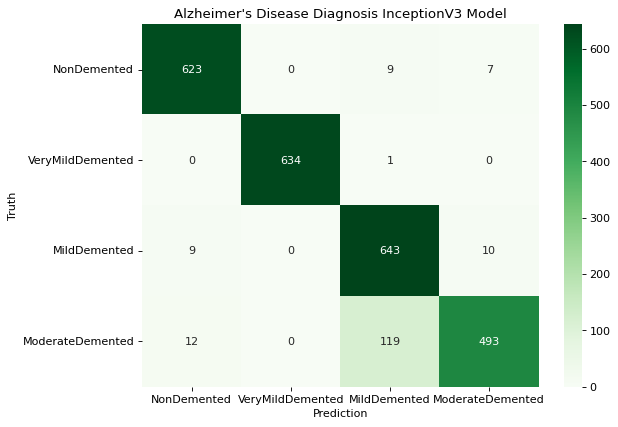

In [42]:
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(cm1, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis InceptionV3 Model')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

**Evaluation of Xception**

In [46]:
model2 = tf.keras.models.load_model('model2B.h5')

In [47]:
yhat2=model2.predict(test_data)
yhat2 = argmax(yhat2, axis=1)
acc2 = accuracy_score(rounded_labels, yhat2)
print('Xception Test Accuracy: %.3f' % acc2)

Xception Test Accuracy: 0.827


In [48]:
cm2 = confusion_matrix(rounded_labels, yhat2)
cm2

array([[509,   0, 116,  14],
       [  0, 627,   6,   2],
       [  2,   1, 657,   2],
       [  2,   1, 296, 325]])

In [49]:
print(classification_report(rounded_labels, yhat2, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      0.80      0.88       639
VeryMildDemented       1.00      0.99      0.99       635
    MildDemented       0.61      0.99      0.76       662
ModerateDemented       0.95      0.52      0.67       624

        accuracy                           0.83      2560
       macro avg       0.89      0.82      0.83      2560
    weighted avg       0.88      0.83      0.83      2560



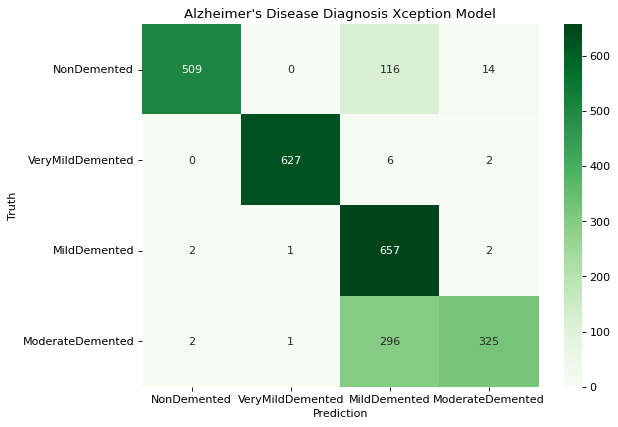

In [50]:
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(cm2, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis Xception Model')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [51]:
model3 = tf.keras.models.load_model('model3C.h5')

In [52]:
yhat3=model3.predict(test_data)
yhat3 = argmax(yhat3, axis=1)
acc3 = accuracy_score(rounded_labels, yhat3)
print('ResNet50 Test Accuracy: %.3f' % acc3)

ResNet50 Test Accuracy: 0.956


In [53]:
cm3 = confusion_matrix(rounded_labels, yhat2)
cm3

array([[509,   0, 116,  14],
       [  0, 627,   6,   2],
       [  2,   1, 657,   2],
       [  2,   1, 296, 325]])

In [54]:
print(classification_report(rounded_labels, yhat3, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      0.96      0.97       639
VeryMildDemented       1.00      0.98      0.99       635
    MildDemented       0.90      0.98      0.94       662
ModerateDemented       0.94      0.90      0.92       624

        accuracy                           0.96      2560
       macro avg       0.96      0.96      0.96      2560
    weighted avg       0.96      0.96      0.96      2560



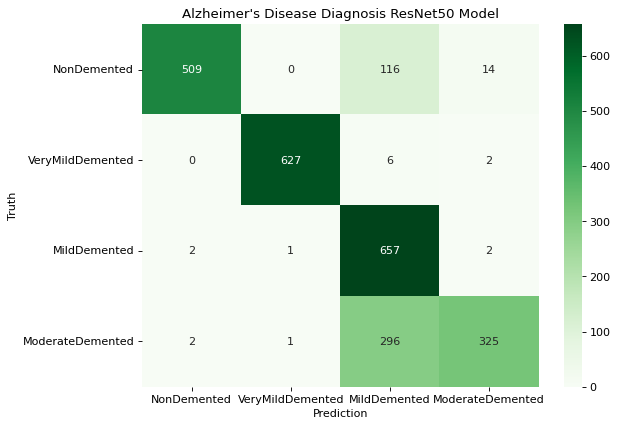

In [55]:
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(cm3, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis ResNet50 Model')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)